In [1]:
#🔧 1 Setup & Imports

In [72]:
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, models, backend as K
from tensorflow.keras.metrics import Precision, Recall
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import (accuracy_score, precision_score, recall_score, 
                             f1_score, classification_report, confusion_matrix,
                             roc_curve, auc, precision_recall_curve)
import seaborn as sns
import matplotlib.pyplot as plt
from collections import defaultdict

np.random.seed(42)
tf.random.set_seed(42)

import os
os.makedirs("results", exist_ok=True)

In [3]:
#🧠 2 Custom Components

In [4]:
class F1Score(tf.keras.metrics.Metric):
    def __init__(self, name='f1_score', **kwargs):
        super().__init__(name=name, **kwargs)
        self.precision = Precision()
        self.recall = Recall()

    def update_state(self, y_true, y_pred, sample_weight=None):
        self.precision.update_state(y_true, y_pred, sample_weight)
        self.recall.update_state(y_true, y_pred, sample_weight)

    def result(self):
        p = self.precision.result()
        r = self.recall.result()
        return 2 * ((p * r) / (p + r + K.epsilon()))

    def reset_state(self):
        self.precision.reset_state()
        self.recall.reset_state()

class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0):
        super().__init__()
        self.alpha = alpha
        self.gamma = gamma

    def call(self, y_true, y_pred):
        y_true = tf.cast(y_true, tf.float32)
        y_pred = K.clip(y_pred, K.epsilon(), 1.0 - K.epsilon())
        ce = -y_true * K.log(y_pred)
        loss = self.alpha * K.pow(1.0 - y_pred, self.gamma) * ce
        return K.mean(loss, axis=-1)

class AttentionLayer(tf.keras.layers.Layer):
    def build(self, input_shape):
        self.W = self.add_weight(name='att_weight', shape=(input_shape[-1], input_shape[-1]), initializer='glorot_uniform')
        self.b = self.add_weight(name='att_bias', shape=(input_shape[-1],), initializer='zeros')
        self.u = self.add_weight(name='att_u', shape=(input_shape[-1], 1), initializer='glorot_uniform')

    def call(self, x):
        uit = K.tanh(K.bias_add(K.dot(x, self.W), self.b))
        ait = K.dot(uit, self.u)
        ait = K.squeeze(ait, -1)
        a = K.softmax(ait)
        a = K.expand_dims(a, -1)
        return K.sum(x * a, axis=1)

In [5]:
#📁 3 Load & Preprocess Data

In [6]:
can_data = pd.read_csv(r"C:\Users\guera\Documents\Python Scripts\ZTA-in-EIV-main\correlated_signal_attack_1_masquerade.csv")
can_data.fillna(0, inplace=True)
signal_columns = [col for col in can_data.columns if "Signal" in col]
can_data['Time'] = pd.to_datetime(can_data['Time'], unit='s')
can_data = can_data.sort_values('Time').set_index('Time')
can_data[signal_columns] = can_data[signal_columns].apply(pd.to_numeric, errors='coerce')
can_data = can_data.resample('100us').mean().interpolate(method='cubic').reset_index()

In [7]:
# 🔁 4 Time-Series Windowing

In [8]:
def create_time_series(data, window_size=50, step_size=5, label_threshold=0.5):
    sequences, labels = [], []
    for i in range(0, len(data) - window_size, step_size):
        window = data.iloc[i:i + window_size]
        label = 1 if window['Label'].mean() >= label_threshold else 0
        sequences.append(window[signal_columns].values)
        labels.append(label)
    return np.array(sequences), np.array(labels)

X, y = create_time_series(can_data, window_size=50, step_size=5, label_threshold=0.5)


In [9]:
#🧪 5 Scaling & Splitting

In [10]:
from sklearn.utils import resample

def balance_classes(X_data, y_data):
    df = pd.DataFrame(X_data.reshape(X_data.shape[0], -1))
    df['Label'] = y_data

    normal = df[df.Label == 0]
    attack = df[df.Label == 1]

    # Upsample attacks to match normal count
    attack_upsampled = resample(attack, replace=True, n_samples=len(normal), random_state=42)
    balanced_df = pd.concat([normal, attack_upsampled])

    X_bal = balanced_df.drop('Label', axis=1).values.reshape(-1, X_data.shape[1], X_data.shape[2])
    y_bal = balanced_df['Label'].values
    return X_bal, y_bal

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, y_train = balance_classes(X_train, y_train)


In [11]:
#🧱 6 Model Builder

In [12]:
def build_model(attention=False, bidirectional=False):
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    if bidirectional:
        x = layers.Bidirectional(layers.LSTM(64, return_sequences=True))(x)
    else:
        x = layers.LSTM(64, return_sequences=True)(x)

    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=attention)(x)

    if attention:
        x = AttentionLayer()(x)
        x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)
    return models.Model(inputs, outputs)

def build_stream_model(attention=False):
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    
    # Causal conv layer
    x = layers.Conv1D(64, kernel_size=3, activation='relu', padding='causal')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.Dropout(0.2)(x)

    # Unidirectional LSTM
    x = layers.LSTM(64, return_sequences=True)(x)
    x = layers.Dropout(0.3)(x)
    x = layers.LSTM(32, return_sequences=attention)(x)

    if attention:
        x = AttentionLayer()(x)
        x = layers.Dropout(0.3)(x)

    x = layers.Dense(32, activation='relu')(x)
    x = layers.Dropout(0.2)(x)
    outputs = layers.Dense(1, activation='sigmoid')(x)

    return models.Model(inputs, outputs)

In [13]:
#🔁 7 Train Models

In [19]:
EPOCHS = 20
BATCH_SIZE = 64
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

model_standard = build_model()
model_standard.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_standard.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

model_stream = build_stream_model(attention=False)
model_stream.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_stream.fit(X_train, y_train, validation_data=(X_test, y_test),
                 epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

model_attention = build_model(attention=True)
model_attention.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_attention.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

#model_focal = build_model()
#model_focal.compile(optimizer='adam',
#                    loss=FocalLoss(alpha=0.5, gamma=1.0),  # Smoothed parameters
#                    metrics=['accuracy', Precision(), Recall(), F1Score()])

#model_focal.fit(X_train, y_train, validation_data=(X_test, y_test),
#                epochs=EPOCHS, batch_size=BATCH_SIZE,
#                callbacks=[early_stop], verbose=2)

model_aug = build_model()
model_aug.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy', Precision(), Recall(), F1Score()])
model_aug.fit(X_train_aug, y_train_aug, validation_data=(X_test, y_test), epochs=EPOCHS, batch_size=BATCH_SIZE, callbacks=[early_stop], verbose=2)

Epoch 1/20
1653/1653 - 19s - 12ms/step - accuracy: 0.9758 - f1_score: 0.9760 - loss: 0.0747 - precision_8: 0.9682 - recall_8: 0.9839 - val_accuracy: 0.9745 - val_f1_score: 0.0965 - val_loss: 0.0865 - val_precision_8: 0.0507 - val_recall_8: 1.0000
Epoch 2/20
1653/1653 - 17s - 11ms/step - accuracy: 0.9892 - f1_score: 0.9893 - loss: 0.0373 - precision_8: 0.9836 - recall_8: 0.9951 - val_accuracy: 0.9841 - val_f1_score: 0.1457 - val_loss: 0.0503 - val_precision_8: 0.0786 - val_recall_8: 1.0000
Epoch 3/20
1653/1653 - 17s - 10ms/step - accuracy: 0.9916 - f1_score: 0.9916 - loss: 0.0307 - precision_8: 0.9867 - recall_8: 0.9966 - val_accuracy: 0.9887 - val_f1_score: 0.1946 - val_loss: 0.0378 - val_precision_8: 0.1078 - val_recall_8: 1.0000
Epoch 4/20
1653/1653 - 18s - 11ms/step - accuracy: 0.9933 - f1_score: 0.9933 - loss: 0.0247 - precision_8: 0.9893 - recall_8: 0.9974 - val_accuracy: 0.9880 - val_f1_score: 0.1846 - val_loss: 0.0490 - val_precision_8: 0.1017 - val_recall_8: 1.0000
Epoch 5/20
1

In [42]:
#🔬 8 Data Augmentation & Training

In [43]:
def jitter(x, sigma=0.03): return x + np.random.normal(0., sigma, x.shape)

attack_idx = np.where(y_train == 1)[0]
X_attack = X_train[attack_idx]

# Generate jittered attack samples
X_aug_attack = np.array([jitter(sample) for sample in X_attack])
y_aug_attack = np.ones(len(X_aug_attack))

# Combine original + augmented
X_train_aug = np.concatenate([X_train, X_aug_attack])
y_train_aug = np.concatenate([y_train, y_aug_attack])

In [44]:
#👥 9 Ensemble Voting

In [45]:
models_list = [model_standard, model_stream, model_attention, model_aug]
model_names = ["Standard", "Streaming", "Attention", "Augmented"]
preds = [m.predict(X_test) for m in models_list]
ensemble_preds = np.mean(preds, axis=0)
y_pred = (ensemble_preds > 0.5).astype(int)

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [46]:
#📊 10 Performance Summary Table

414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

🔍 Model Performance Summary:
        Model  Accuracy  Precision    Recall        F1
0   Standard  0.995921   0.250000  1.000000  0.400000
2  Attention  0.994939   0.204819  0.944444  0.336634
1  Streaming  0.992900   0.160714  1.000000  0.276923
3  Augmented  0.991918   0.138211  0.944444  0.241135


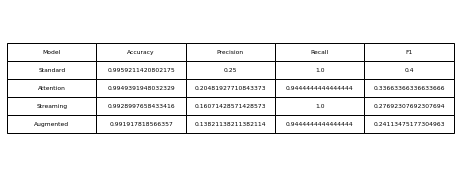

In [73]:
metrics_summary = defaultdict(list)

for name, model in zip(model_names, models_list):
    y_pred_model = (model.predict(X_test) > 0.5).astype(int)
    metrics_summary['Model'].append(name)
    metrics_summary['Accuracy'].append(accuracy_score(y_test, y_pred_model))
    metrics_summary['Precision'].append(precision_score(y_test, y_pred_model))
    metrics_summary['Recall'].append(recall_score(y_test, y_pred_model))
    metrics_summary['F1'].append(f1_score(y_test, y_pred_model))

df_summary = pd.DataFrame(metrics_summary).sort_values('F1', ascending=False)
print("\n🔍 Model Performance Summary:\n", df_summary)

# Save metrics summary to text
df_summary.to_csv("results/metrics_summary.txt", sep='\t', index=False)

# Optional: save to PDF using matplotlib
import matplotlib.backends.backend_pdf
pdf = matplotlib.backends.backend_pdf.PdfPages("results/metrics_summary.pdf")

fig, ax = plt.subplots(figsize=(8, 3))
ax.axis('tight')
ax.axis('off')
table = ax.table(cellText=df_summary.values,
                 colLabels=df_summary.columns,
                 cellLoc='center', loc='center')
table.scale(1, 1.5)
pdf.savefig(fig)
pdf.close()


In [48]:
#🔍 11 Threshold Optimization

In [49]:
thresholds = np.arange(0.1, 0.9, 0.01)
best_f1 = 0.0
best_threshold = 0.5
f1_scores = []

for threshold in thresholds:
    y_pred_thresh = (ensemble_preds > threshold).astype(int)
    f1 = f1_score(y_test, y_pred_thresh)
    f1_scores.append(f1)
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\n📍 Optimal Threshold = {best_threshold:.2f} with F1-Score = {best_f1:.4f}")


📍 Optimal Threshold = 0.88 with F1-Score = 0.4638


In [50]:
#📉 12 F1 Score Curve by Threshold

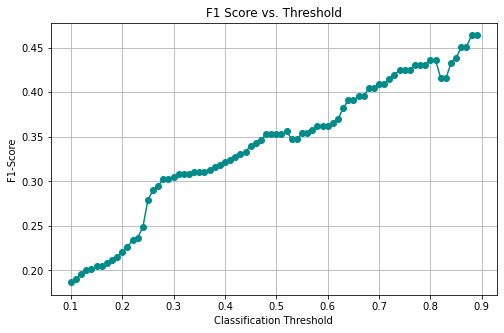

In [74]:
plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o', color='darkcyan')
plt.xlabel('Classification Threshold')
plt.ylabel('F1-Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.show()

plt.figure(figsize=(8, 5))
plt.plot(thresholds, f1_scores, marker='o', color='darkcyan')
plt.xlabel('Classification Threshold')
plt.ylabel('F1-Score')
plt.title('F1 Score vs. Threshold')
plt.grid(True)
plt.savefig("results/f1_vs_threshold.png", dpi=300)
plt.close()


In [52]:
#🎯 13 Evaluation with Optimal Threshold

In [78]:
y_pred_opt = (ensemble_preds > best_threshold).astype(int)

print("\n🧮 Final Evaluation (Optimized Threshold):")
print(classification_report(y_test, y_pred_opt, target_names=["Normal", "Attack"]))
print(f"Accuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
print(f"Precision: {precision_score(y_test, y_pred_opt):.4f}")
print(f"Recall: {recall_score(y_test, y_pred_opt):.4f}")
print(f"F1-score: {f1_score(y_test, y_pred_opt):.4f}")

# Save final classification metrics
with open("results/final_evaluation.txt", "w") as f:
    f.write("Final Evaluation (Optimized Threshold):\n")
    f.write(classification_report(y_test, y_pred_opt, target_names=["Normal", "Attack"]))
    f.write(f"\nAccuracy: {accuracy_score(y_test, y_pred_opt):.4f}")
    f.write(f"\nPrecision: {precision_score(y_test, y_pred_opt):.4f}")
    f.write(f"\nRecall: {recall_score(y_test, y_pred_opt):.4f}")
    f.write(f"\nF1-score: {f1_score(y_test, y_pred_opt):.4f}")



🧮 Final Evaluation (Optimized Threshold):
              precision    recall  f1-score   support

      Normal       1.00      1.00      1.00     13221
      Attack       0.31      0.89      0.46        18

    accuracy                           1.00     13239
   macro avg       0.66      0.94      0.73     13239
weighted avg       1.00      1.00      1.00     13239

Accuracy: 0.9972
Precision: 0.3137
Recall: 0.8889
F1-score: 0.4638


In [54]:
# 📊 14 Confusion Matrix

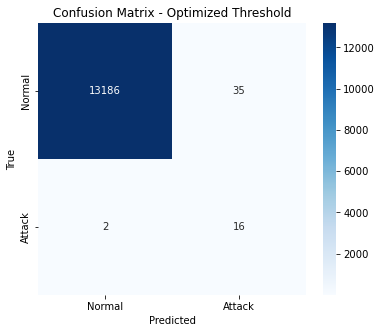

In [75]:
cm = confusion_matrix(y_test, y_pred_opt)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=["Normal", "Attack"], yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - Optimized Threshold")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

fig_cm = plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=["Normal", "Attack"],
            yticklabels=["Normal", "Attack"])
plt.title("Confusion Matrix - Optimized Threshold")
plt.xlabel("Predicted")
plt.ylabel("True")
fig_cm.savefig("results/confusion_matrix.png", dpi=300)
plt.close()


In [56]:
#🧪 15 ROC Curve & Precision-Recall AUC

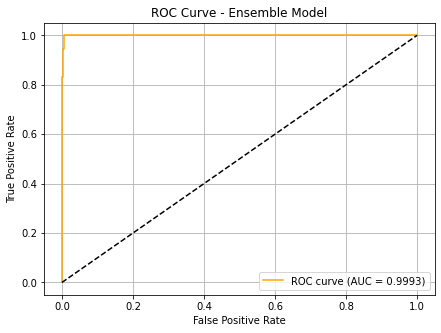

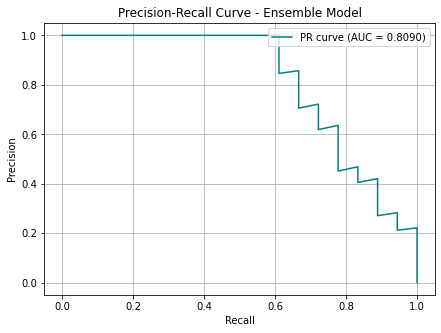

In [76]:
# ROC Curve
fpr, tpr, _ = roc_curve(y_test, ensemble_preds)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend(loc='lower right')
plt.grid(True)
plt.show()

# Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, ensemble_preds)
pr_auc = auc(recall, precision)

plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})', color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble Model')
plt.legend(loc='upper right')
plt.grid(True)
plt.show()

# ROC
plt.figure(figsize=(7, 5))
plt.plot(fpr, tpr, label=f'ROC curve (AUC = {roc_auc:.4f})', color='orange')
plt.plot([0, 1], [0, 1], 'k--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Ensemble Model')
plt.legend()
plt.grid(True)
plt.savefig("results/roc_curve.png", dpi=300)
plt.close()

# PR
plt.figure(figsize=(7, 5))
plt.plot(recall, precision, label=f'PR curve (AUC = {pr_auc:.4f})', color='teal')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve - Ensemble Model')
plt.legend()
plt.grid(True)
plt.savefig("results/precision_recall_curve.png", dpi=300)
plt.close()


In [58]:
#🧪 16 Stratified Cross-Validation

In [59]:
from sklearn.model_selection import StratifiedKFold

def cross_validate_model(build_fn, X, y, folds=5):
    skf = StratifiedKFold(n_splits=folds, shuffle=True, random_state=42)
    results = []

    for fold, (train_idx, val_idx) in enumerate(skf.split(X, y)):
        print(f"📦 Fold {fold + 1}/{folds}")
        model = build_fn()
        model.compile(optimizer='adam', loss='binary_crossentropy', metrics=[F1Score(), Precision(), Recall()])
        model.fit(X[train_idx], y[train_idx], validation_data=(X[val_idx], y[val_idx]),
                  epochs=10, batch_size=64, callbacks=[early_stop], verbose=0)
        preds = (model.predict(X[val_idx]) > 0.5).astype(int)
        results.append(f1_score(y[val_idx], preds))
    
    print(f"\n✅ Avg F1 across folds: {np.mean(results):.4f}")
    return results


In [60]:
#🧠 17 Contrastive Learning Module (Siamese Network)

In [61]:
def build_embedding_model():
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)
    x = layers.LSTM(64, return_sequences=False)(x)
    x = layers.Dense(128, activation='relu')(x)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Lambda(lambda x: K.l2_normalize(x, axis=1))(x)
    return models.Model(inputs, outputs)

def euclidean_distance(vects):
    x, y = vects
    return K.sqrt(K.sum(K.square(x - y), axis=1, keepdims=True))

def contrastive_loss(y_true, dist, margin=1):
    return K.mean(y_true * K.square(dist) + (1 - y_true) * K.square(K.maximum(margin - dist, 0)))

input_a = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))
input_b = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))

embedding_net = build_embedding_model()
feat_a = embedding_net(input_a)
feat_b = embedding_net(input_b)

distance = layers.Lambda(euclidean_distance)([feat_a, feat_b])
siamese_net = models.Model(inputs=[input_a, input_b], outputs=distance)
siamese_net.compile(optimizer='adam', loss=lambda y, d: contrastive_loss(y, d))


In [62]:
#🧪 18 Monte Carlo Dropout Model for Uncertainty Estimation

In [64]:
class MCDropoutModel(tf.keras.Model):
    def __init__(self):
        super().__init__()
        self.conv = layers.Conv1D(64, kernel_size=3, activation='relu', padding='same')
        self.pool = layers.MaxPooling1D(2)
        self.drop1 = layers.Dropout(0.5)
        self.lstm1 = layers.LSTM(64, return_sequences=True)
        self.drop2 = layers.Dropout(0.5)
        self.lstm2 = layers.LSTM(32)
        self.dense = layers.Dense(32, activation='relu')
        self.drop3 = layers.Dropout(0.5)
        self.output_layer = layers.Dense(1, activation='sigmoid')

    def call(self, inputs, training=False):
        x = self.conv(inputs)
        x = self.pool(x)
        x = self.drop1(x, training=training)
        x = self.lstm1(x)
        x = self.drop2(x, training=training)
        x = self.lstm2(x)
        x = self.dense(x)
        x = self.drop3(x, training=training)
        return self.output_layer(x)



In [65]:
#🧪 19 Temporal Perturbation Functions

In [66]:
def add_time_jitter(data, max_shift=3):
    jittered = []
    for window in data:
        shift = np.random.randint(-max_shift, max_shift + 1)
        jittered.append(np.roll(window, shift, axis=0))
    return np.array(jittered)

def mask_random_signals(data, mask_ratio=0.2):
    masked = data.copy()
    for i in range(data.shape[0]):
        mask_channels = np.random.choice(data.shape[-1], int(data.shape[-1] * mask_ratio), replace=False)
        masked[i][:, mask_channels] = 0
    return masked

X_jittered = add_time_jitter(X_test, max_shift=5)
X_masked = mask_random_signals(X_test, mask_ratio=0.3)

# ⚖️ Compare original and perturbed predictions
for desc, X_variant in zip(['Clean', 'Time-Jittered', 'Signal-Masked'], [X_test, X_jittered, X_masked]):
    y_pred_var = (model_attention.predict(X_variant) > 0.5).astype(int)
    print(f"\n📉 {desc} Data:")
    print(f"Accuracy: {accuracy_score(y_test, y_pred_var):.4f}, F1: {f1_score(y_test, y_pred_var):.4f}")


414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📉 Clean Data:
Accuracy: 0.9949, F1: 0.3366
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📉 Time-Jittered Data:
Accuracy: 0.9949, F1: 0.3366
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step

📉 Signal-Masked Data:
Accuracy: 0.9760, F1: 0.0862


In [ ]:
# 🧠 20 Temporal Shift Detection with t-SNE + KL Divergence

Epoch 1/5
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 38s 21ms/step - loss: 37956232.0000
Epoch 2/5
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - loss: 37808192.0000
Epoch 3/5
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 35s 21ms/step - loss: 37668752.0000
Epoch 4/5
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 37534736.0000
Epoch 5/5
1653/1653 ━━━━━━━━━━━━━━━━━━━━ 34s 21ms/step - loss: 37405504.0000
414/414 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
63/63 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step
39/39 ━━━━━━━━━━━━━━━━━━━━ 0s 2ms/step


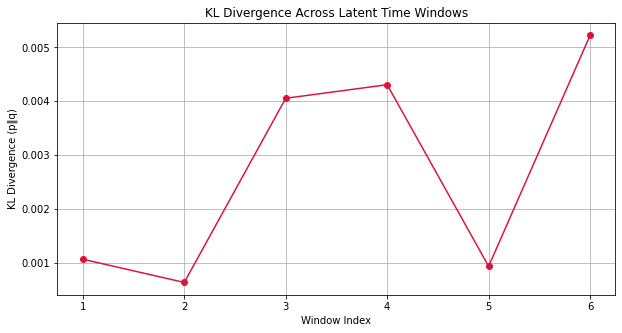

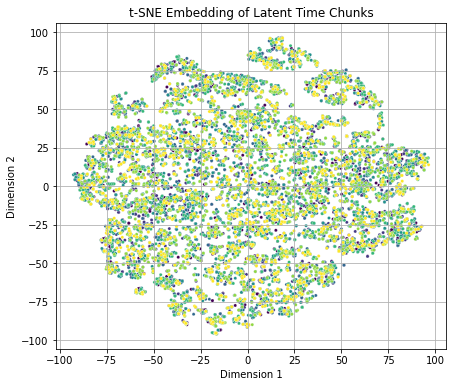

In [70]:
from sklearn.manifold import TSNE
from scipy.stats import entropy
from sklearn.decomposition import PCA
import seaborn as sns

def build_autoencoder():
    inputs = tf.keras.Input(shape=(X_train.shape[1], X_train.shape[2]))  # (50, 22)
    
    # Encoder
    x = layers.Conv1D(64, 3, activation='relu', padding='same')(inputs)
    x = layers.MaxPooling1D(2)(x)  # (25, 64)
    x = layers.LSTM(64)(x)
    x = layers.Dense(64, activation='relu')(x)
    latent = layers.Dense(32, activation='relu', name='latent_vec')(x)

    # Decoder
    x = layers.RepeatVector(X_train.shape[1])(latent)  # Repeat to 50 timesteps
    x = layers.LSTM(64, return_sequences=True)(x)
    outputs = layers.TimeDistributed(layers.Dense(X_train.shape[2]))(x)  # (50, 22)

    return models.Model(inputs, outputs)

autoencoder = build_autoencoder()
autoencoder.compile(optimizer='adam', loss='mse')
autoencoder.fit(X_train, X_train, epochs=5, batch_size=64, verbose=1)

encoder = models.Model(inputs=autoencoder.input, outputs=autoencoder.get_layer('latent_vec').output)
latent_reps = encoder.predict(X_test)

# Step 2: Extract Latent Space from Different Time Periods
def get_batches_by_time(X_data, time_vector, batch_size=2000):
    """Split into consecutive time chunks based on timestamp"""
    chunks = []
    timestamps = time_vector[:len(X_data)]
    for i in range(0, len(X_data), batch_size):
        chunks.append(X_data[i:i + batch_size])
    return chunks

time_chunks = get_batches_by_time(X_test, can_data['Time'].values, batch_size=2000)

# Step 3: Project Each Chunk to Latent Space
chunk_latents = [encoder.predict(chunk) for chunk in time_chunks]

# Step 4: Estimate KL Divergence Between Consecutive Chunks
kl_scores = []
for i in range(1, len(chunk_latents)):
    p = np.histogram(chunk_latents[i-1], bins=50, density=True)[0] + 1e-8
    q = np.histogram(chunk_latents[i], bins=50, density=True)[0] + 1e-8
    p /= p.sum()
    q /= q.sum()
    kl = entropy(p, q)
    kl_scores.append(kl)

import matplotlib.pyplot as plt
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(kl_scores)+1), kl_scores, marker='o', color='crimson')
plt.title("KL Divergence Across Latent Time Chunks")
plt.xlabel("Window Index")
plt.ylabel("KL Divergence (p‖q)")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/kl_divergence_plot.png", dpi=300)
plt.close()

from sklearn.manifold import TSNE
import seaborn as sns

all_latents = np.concatenate(chunk_latents, axis=0)
chunk_labels = np.repeat(range(len(chunk_latents)), [len(c) for c in chunk_latents])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(all_latents)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1],
                hue=chunk_labels, palette='viridis', s=12, legend=None)
plt.title("t-SNE Embedding of Latent Signal Chunks")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/tsne_plot.png", dpi=300)
plt.close()




In [80]:
# Ensure results directory exists
import os
os.makedirs("results", exist_ok=True)

# Save KL divergence values over time windows
with open("results/kl_divergence_scores.txt", "w", encoding="utf-8") as f:
    f.write("KL Divergence Across Latent Time Chunks\n")
    f.write("Window_Index\tKL_Divergence\n")
    for idx, kl in enumerate(kl_scores, start=1):
        f.write(f"{idx}\t{kl:.6f}\n")
    
    # Highlight peak window
    peak_idx = np.argmax(kl_scores) + 1
    peak_val = kl_scores[peak_idx - 1]
    f.write(f"\nPeak KL Divergence at Window {peak_idx}: {peak_val:.6f}\n")
    f.write(f"KL Range: {min(kl_scores):.6f} to {max(kl_scores):.6f}\n")


In [81]:
import matplotlib.pyplot as plt
os.makedirs("results", exist_ok=True)

plt.figure(figsize=(10, 5))
plt.plot(range(1, len(kl_scores)+1), kl_scores, marker='o', color='crimson')
plt.title("KL Divergence Across Latent Time Chunks")
plt.xlabel("Window Index")
plt.ylabel("KL Divergence (p‖q)")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/kl_divergence_plot.png", dpi=300)
plt.close()

from sklearn.manifold import TSNE
import seaborn as sns

all_latents = np.concatenate(chunk_latents, axis=0)
chunk_labels = np.repeat(range(len(chunk_latents)), [len(c) for c in chunk_latents])

tsne = TSNE(n_components=2, perplexity=30, random_state=42)
embedded = tsne.fit_transform(all_latents)

plt.figure(figsize=(8, 6))
sns.scatterplot(x=embedded[:, 0], y=embedded[:, 1],
                hue=chunk_labels, palette='viridis', s=12, legend=None)
plt.title("t-SNE Embedding of Latent Signal Chunks")
plt.xlabel("Dimension 1")
plt.ylabel("Dimension 2")
plt.grid(True)
plt.tight_layout()
plt.savefig("results/tsne_plot.png", dpi=300)
plt.close()
